In [1]:
# https://github.com/clovaai/deep-text-recognition-benchmark#download-lmdb-dataset-for-traininig-and-evaluation-from-here
# https://github.com/clovaai/CRAFT-pytorch
# https://pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ Non maximum suppression

In [2]:
# TODO rifinire singole bounding boxes: capire se sono ruotate e raddrizzarle per eccesso per facilitare l'ocr? OK

In [3]:
import json
import os
import numpy as np
import urllib.parse
from PIL import Image
import cv2
import types
from collections import namedtuple
import shutil

In [4]:
cwd=os.getcwd()


### paths

In [5]:
import os

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.abspath(os.path.join(root, name)))
    return r

In [6]:
orig_imgs_paths=list_files(f'{cwd}/test_images/post_imgs/TEST/')

In [7]:
try:
    os.mkdir(f'{cwd}/output')
except:
    pass

try:
    os.mkdir(f'{cwd}/output/processed_images')
except:
    pass

processed_images_folder=f'{cwd}/output/processed_images/'
bboxes_path = f"{processed_images_folder}bboxes_infos.json"

In [8]:
for p in orig_imgs_paths:
    shutil.copyfile(p, f"{cwd}/output/processed_images/{p.split('/')[-1]}")
with open(bboxes_path) as f:
    boxes_data_raw=json.load(f)

In [9]:
_IMAGE=orig_imgs_paths[2]

In [10]:
Image.open(_IMAGE)
orig_img=Image.open(_IMAGE)
width, height= orig_img.size

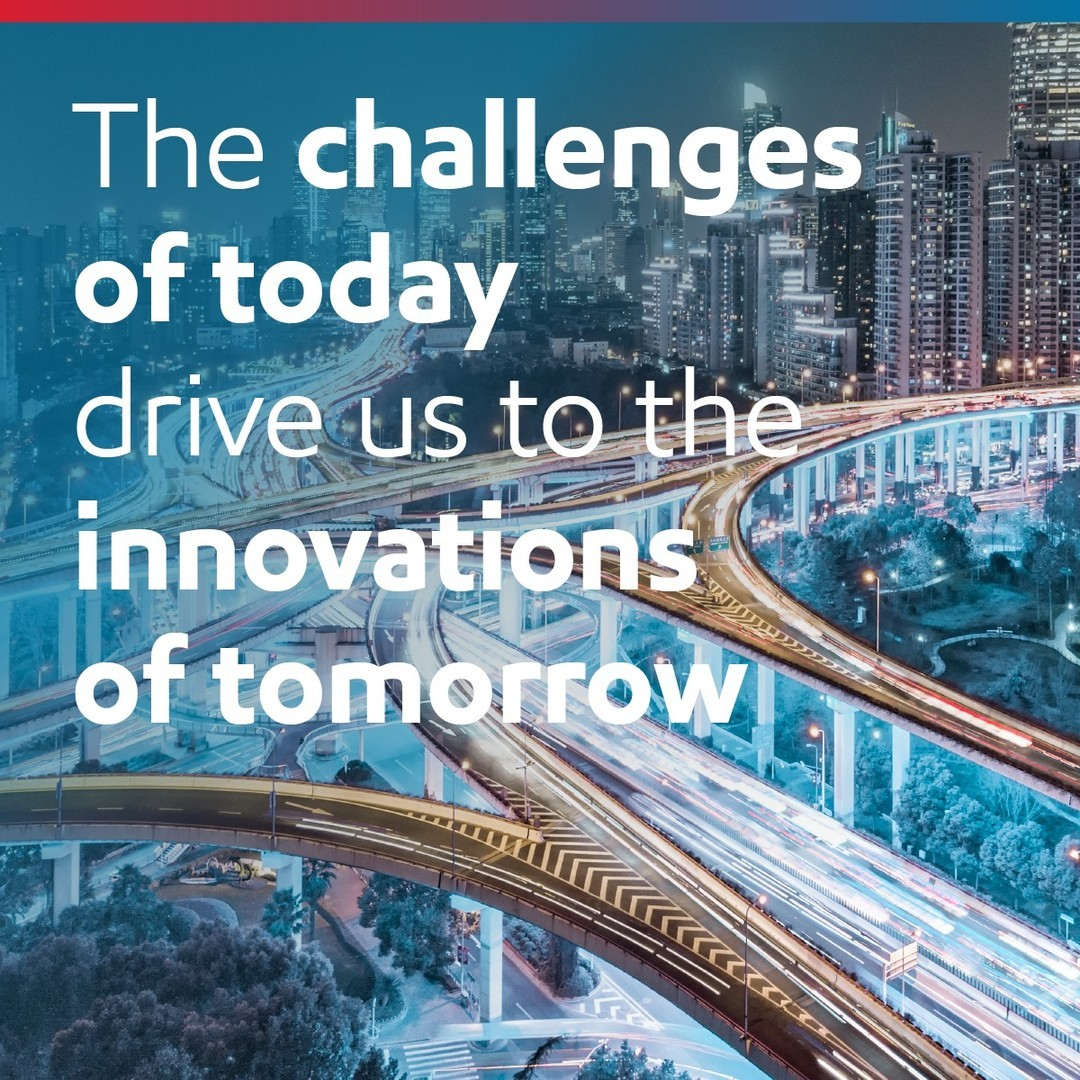

In [11]:
Image.open(_IMAGE)

In [12]:
import tempfile
import itertools as IT
import os

def show_cv_to_pil(cv_img):
        "Auxiliary function to fix opencv.show() not working on linux"
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(cv_img)
        im_pil.show()
        

def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path


def check_and_save(dir_path, file_name=str):
    # Save
    if os.path.isdir(dir_path):
        pass
    else:
        os.mkdir(dir_path)
        
    saving_dir=dir_path
        
    f=uniquify(dir_path+'/'+file_name)
    return saving_dir, f


In [32]:
from sklearn.cluster import MeanShift
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Any
from pathlib import Path

class BoxesEngine():
    
    @classmethod
    def make_b_list(self, boxes_data_raw, processed_image_path ):
        Idx_Box=namedtuple("Idx_Box", "id top_left bottom_right dx dy")
        tldr_boxes={}
        n=0
        for k, v in boxes_data_raw.items():
            tldr_boxes[k]=[self.xy_box_to_tl_br(box_vertices=box) for box in v]

        for k, v in tldr_boxes.items():
            for i in range(len(v)):
                v[i]=Idx_Box(i, *v[i])
        return tldr_boxes[processed_image_path.split('/')[-1]], tldr_boxes
    
    @classmethod
    def extract_area_of_4boxes_list(self, list_bboxes):
        "Extract area of a list of boxes in 4 vertex format"
        a=0.0
        for box in list_bboxes:
            dx=round(max(box[0][0], box[1][0]) - min(box[0][0], box[1][0]), 2)
            dy=round(max(box[0][1], box[3][1]) - min(box[0][1], box[3][1]), 2)
            a+=dx*dy
        return round(a, 0)
    
    @classmethod
    def extract_area_of_tl_br_box_list(self,tl_br_tup_lst):
        "Calculate area of a tl_dr box list"
        a=0.0
        for tl_br_tup in tl_br_tup_lst:
            dx=round(max(tl_br_tup[0][0], tl_br_tup[1][0]) - min(tl_br_tup[0][0], tl_br_tup[1][0]), 0)
            dy=round(max(tl_br_tup[0][1], tl_br_tup[1][1]) - min(tl_br_tup[0][1], tl_br_tup[1][1]), 0)
            a+= int(dx*dy)
        return a
    
    @classmethod
    def xy_box_to_tl_br(self,box_vertices):
        """Transform 4-vertex box to named tuple:
        Box = namedtuple("Box", "top_left bottom_right dx dy")"""
        Box = namedtuple("Box", "top_left bottom_right dx dy")
        tl=[min([v[0] for v in box_vertices]), min([v[1] for v in box_vertices])]
        br=[max([v[0] for v in box_vertices]), max([v[1] for v in box_vertices])]
        dx=round(max(box_vertices[0][0], box_vertices[1][0]) - min(box_vertices[0][0], box_vertices[1][0]), 2)
        dy=round(max(box_vertices[0][1], box_vertices[3][1]) - min(box_vertices[0][1], box_vertices[3][1]), 2)

        return Box(tl, br, dx, dy)

    @classmethod
    def tl_br_list_to_centers(self, tl_dr_Idx_Box, round_to=2):
        "Extract boxes centers from list of Idx_Box named tuple"
        centers=[]
        for box in tl_dr_Idx_Box:
            if round_to >0:
                centers.append((box.id, [round(box.top_left[0] + 0.5*(box.dx), round_to), round(box.top_left[1] + 0.5*(box.dy) , round_to) ]))
            else:
                centers.append((box.id, [int(box.top_left[0] + 0.5*(box.dx)), int(box.top_left[1] + 0.5*(box.dy)) ]))
        return centers

    @classmethod
    def create_big_box_from_ids(self, ids, boxes_data, tolerance_x, tolerance_y):
        "Merge boxes from id list into a single box"
        to_bound=[]
        for box in boxes_data:
            if getattr(box, 'id') in ids: to_bound.append(box) 
            
        to_bound.sort(key=lambda a: a.top_left[0])
        TLx=to_bound[0].top_left[0] - tolerance_x
        to_bound.sort(key=lambda a: a.top_left[1])
        TLy=to_bound[0].top_left[1] - tolerance_y

        to_bound.sort(key=lambda a: a.bottom_right[0])
        BRx=to_bound[-1].bottom_right[0] + tolerance_x
        to_bound.sort(key=lambda a: a.bottom_right[1])
        BRy=to_bound[-1].bottom_right[1] + tolerance_y

        return [(int(TLx), int(TLy)), (int(BRx), int(BRy))]
    
    @classmethod
    def check_tl_br_boxes_intersection(self, b1, b2):
        """
           box1=[(x_0, y_0), (x_1, y_1)]
           box2=[(x_0, y_0), (x_1, y_1)] 
        """
        startX = max( min(b1[0][0], b1[1][0]), min(b2[0][0], b2[1][0]) )
        startY = max( min(b1[0][1], b1[1][1]), min(b2[0][1], b2[1][1]) )

        endX = min( max(b1[0][0], b1[1][0]), max(b2[0][0], b2[1][0]) )
        endY = min( max(b1[0][1], b1[1][1]), max(b2[0][1], b2[1][1]) )

        if startX < endX and startY < endY:
            return True
        else:
            return False
        
    @classmethod
    def cluster_up_intersecting_boxes_list(self, tl_br_boxes_list):
        boxes=tl_br_boxes_list.copy()
        box=tl_br_boxes_list[0]
        cluster=[box] #initializing cluster from the 1st box
        cluster_against=boxes[1:]

        for idx, cl in enumerate(cluster_against):
            if self.check_tl_br_boxes_intersection(box, cluster_against[idx]):
                cluster.append(cluster_against[idx])
            else:
                continue
        for c in cluster:
            boxes.remove(c)
        remain=boxes
        return cluster[0], remain
    
    
    @classmethod
    def extract_text_clusters(self, image, b_list, tldr_boxes):
    
        boxes_centers=self.tl_br_list_to_centers(b_list, round_to=2)
        X = np.array([c[1] for c in boxes_centers])
        clst = MeanShift(bandwidth=None).fit(X)
        cluster_id_to_box_id=list(zip(clst.labels_, [c[0] for c in boxes_centers]))
        clustered_boxes = defaultdict(list)
        
        for x in cluster_id_to_box_id:
            clustered_boxes[x[0]].append(x[1])
        clustered_boxes_ids=dict(clustered_boxes)

        tl_br_clustered_text_boxes=[]
        for k, v in clustered_boxes_ids.items():
            tl_br_clustered_text_boxes.append(boxes_engine.create_big_box_from_ids(v, tldr_boxes[image.split('/')[-1]], tolerance_x=10, tolerance_y=15))
        return tl_br_clustered_text_boxes, clustered_boxes_ids
    
    @classmethod
    def isolate_box(self, bw_img, box ):
        bwimage = cv2.rectangle(bw_img, (box[0], box[1]), (box[2], box[3]), 255, 1)

        # create list of corners with bbox index
        corners = []
        for i, bbox in enumerate(bbox_list):
            corners.append((box[0], box[1], i))
            corners.append((box[0], box[3], i))
            corners.append((box[2], box[1], i))
            corners.append((box[2], box[3], i))

        # for each corner find nearest border
        for c in corners:
            min_dist = float('inf')
            min_dist_i = None
            min_dist_type = None
            for i, bb in enumerate(bbox_list):
                for side in range(4):
                    thisdim = side % 2
                    otherdim = 1 - thisdim
                    dist = abs(c[thisdim] - bb[side])
                    if dist == 0 and c[2] == i:
                        pass
                    elif min_dist > dist and bb[otherdim] < c[otherdim] < bb[otherdim + 2]:
                        min_dist = dist
                        min_dist_i = i
                        min_dist_type = side

            if min_dist_i is not None:
                bb = bbox_list[min_dist_i]
                if min_dist_type % 2 == 0:
                    dest = (bb[min_dist_type], c[1])
                else:
                    dest = (c[0], bb[min_dist_type])
                bwimg_contours_only = cv2.line(bw_img, (c[0], c[1]), dest, 255, 1)
        return bwimg_contours_only
    
    @classmethod
    def merge_boxes(self, boxes_list, max_clusters_n=4  ):
        CLUSTERS=[]
        check=True
        cluster, remaining =self.cluster_up_intersecting_boxes_list(boxes_list)
        CLUSTERS.append(cluster)
        
        for mc in range(max_clusters_n):
            if len(remaining)>1:
                cluster, rest = self.cluster_up_intersecting_boxes_list(remaining)
                CLUSTERS.append(cluster)
                remaining=rest
                mc+=1
                continue
            else:
                CLUSTERS.append(rest[0])
                break

        bbox_list=[[*x[0], *x[1]] for x in CLUSTERS]
        return bbox_list
    
    @classmethod
    def _crop_clean_save_text_box(self, orig_img_path, tl_br_clustered_text_boxes):
        orig_img=cv2.imread(orig_img_path)
        boxes_on_black=np.zeros(orig_img.shape, np.uint8)
        for r in tl_br_clustered_text_boxes:
            cv2.rectangle(boxes_on_black, r[0], r[1], (255, 0, 0), 2)
            
        img_grey = cv2.cvtColor(boxes_on_black,cv2.COLOR_BGR2GRAY)
        ret, thresh_boxes_on_black = cv2.threshold(img_grey, cv2.THRESH_BINARY, 255, cv2.THRESH_BINARY)
        contours, hierarchy=cv2.findContours(thresh_boxes_on_black,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        parts=[]
        paths=[]
        for c in range(len(contours)):
            mask=np.zeros(orig_img.shape, np.uint8)
            not_mask=np.ones(orig_img.shape, np.uint8)
            cv2.drawContours(mask, contours, c, (1, 1, 1), -1) # mask, contour, CONTOUR INDEX
            cv2.drawContours(not_mask, contours, c, (1, 1, 1), -1) # mask, contour, CONTOUR INDEX
            final_img = mask * orig_img
            background_img = (not_mask-mask) * orig_img
            #show_cv_to_pil(final_img)
            parts.append(final_img)
            saving_dir, unified_file_path=check_and_save(dir_path=f'{cwd}/output/{Path(orig_img_path).stem}', file_name=f"{Path(orig_img_path).stem}.png")
            cv2.imwrite(unified_file_path, final_img)
            paths.append(unified_file_path)
        # Save background    
        saving_dir, unified_file_path_bg=check_and_save(dir_path=f'{cwd}/output/{Path(orig_img_path).stem}', file_name=f"{Path(orig_img_path).stem}_background.png")
        print(unified_file_path_bg)
        cv2.imwrite(unified_file_path_bg, background_img)
        
        return parts, paths, background_img, unified_file_path_bg
    
    
    

In [33]:
boxes_engine=BoxesEngine()

In [34]:
f"Pct area covered by text boxes: {round((boxes_engine.extract_area_of_4boxes_list(boxes_data_raw[_IMAGE.split('/')[-1]]) / (width*height))*100, 2)}%"


'Pct area covered by text boxes: 25.5%'

In [35]:
b_list, tldr_boxes=boxes_engine.make_b_list(boxes_data_raw=boxes_data_raw, processed_image_path=_IMAGE)

In [36]:
b_list

[Idx_Box(id=0, top_left=[294.48748779296875, 86.99515533447266], bottom_right=[868.0977172851562, 221.35028076171875], dx=569.59, dy=114.3),
 Idx_Box(id=1, top_left=[74.25, 97.875], bottom_right=[268.3125, 192.375], dx=194.06, dy=94.5),
 Idx_Box(id=2, top_left=[204.5643768310547, 217.67034912109375], bottom_right=[521.1890869140625, 349.21826171875], dx=308.8, dy=109.49),
 Idx_Box(id=3, top_left=[75.9375, 232.875], bottom_right=[190.6875, 327.375], dx=114.75, dy=94.5),
 Idx_Box(id=4, top_left=[74.42256927490234, 363.45062255859375], bottom_right=[327.3338623046875, 466.473388671875], dx=250.55, dy=96.91),
 Idx_Box(id=5, top_left=[633.5214233398438, 364.7330627441406], bottom_right=[807.6913452148438, 461.33740234375], dx=172.77, dy=94.03),
 Idx_Box(id=6, top_left=[494.4375, 379.6875], bottom_right=[605.8125, 459.0], dx=111.38, dy=79.31),
 Idx_Box(id=7, top_left=[359.4375, 383.0625], bottom_right=[470.8125, 460.6875], dx=111.38, dy=77.62),
 Idx_Box(id=8, top_left=[73.24930572509766, 500

### Solution: MeanShift clustering

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
# https://www.cse.psu.edu/~rtc12/CSE598G/introMeanShift.pdf

In [38]:
tl_br_clustered_text_boxes, clustered_boxes_ids=boxes_engine.extract_text_clusters(image=_IMAGE, b_list=b_list, tldr_boxes=tldr_boxes)

In [39]:
orig_img_shape=(orig_img.width, orig_img.height)

In [40]:
f"[enhanced] Pct area covered by text boxes: {round(boxes_engine.extract_area_of_tl_br_box_list(tl_br_clustered_text_boxes)/(orig_img_shape[0]*orig_img_shape[1])*100, 2)}%"

'[enhanced] Pct area covered by text boxes: 52.56%'

In [41]:
P, cropped_paths, background , background_path= boxes_engine._crop_clean_save_text_box(_IMAGE, tl_br_clustered_text_boxes)


/home/atogni/Desktop/ocr_gradient/craft_model/output/Cb8fMmqFr6u/Cb8fMmqFr6u_background (1).png


In [42]:
#show_cv_to_pil(background)

In [44]:
masked_text_boxes={}
for i, path in enumerate(cropped_paths[::-1]): # 
    #show_cv_to_pil(P[i])
    masked_text_boxes[i]={'image_path': path, 'background_path': '' ,'pytesseract_text': '', 'unskewed_text': '', 'paddle_text': '', 'skew_angle': '', 'unskewed_image_path': '',  'full_caps': '', 
                          'oversized': '', 'linguistic_features': {'full': '', 'noun_chunks': ''}}
    masked_text_boxes[i]['background_path']=background_path

### Background classification 

### OCR pytesseract

In [46]:
# pip install -U spacy
# python -m spacy download en_core_web_lg

In [47]:
import pytesseract
from pytesseract import Output
import pandas as pd
from paddleocr import PaddleOCR
import re
import spacy
nlp = spacy.load('en_core_web_lg')

In [48]:

class OcrEngine():
    
    @classmethod
    def text_skew_correction(self, rgb_text_box):
        gray = cv2.cvtColor(rgb_text_box, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        thresh = cv2.threshold(gray, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]
        # Angle from -(90, 0] to [0,90)
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = 90-angle

        (h, w) = rgb_text_box.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        unskewed = cv2.warpAffine(rgb_text_box, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return unskewed, angle
    
    @classmethod
    def _preprocess(self, img_text_box):
        # TODO consider adaptive thresholding
        unskewed_gray, _=self.text_skew_correction(img_text_box)
        gray = cv2.cvtColor(unskewed_gray, cv2.COLOR_BGR2GRAY)
        return gray
    
    @classmethod
    def extract_uppers(self, T):
        "Extract list of upper case words from a string of text"
        uppers=[]
        for word in T.split(' '):
            if word.isupper():
                uppers.append(word)
            else:
                continue
        return uppers
    
    @classmethod
    def preprocess_and_extract_test_pytess(self, img_text_box):
        gray_text_box=self._preprocess(img_text_box)
        text = pytesseract.image_to_string(gray_text_box)
        return ' '.join(text.split()), gray_text_box
    
    @classmethod
    def preprocess_and_extract_test_paddle(self, img_path):
        paddle_ocr = PaddleOCR(use_angle_cls=True, lang='en')
        result = paddle_ocr.ocr(img_path, cls=False)
        return ' '.join([r[-1][0] for r in result])
    
    @classmethod
    def extract_size_highlighted(self, processed_image):
        d = pytesseract.image_to_data(processed_image, output_type=Output.DICT)
        R=[]
        for i in range(len(d['level'])):
            if d['word_num'][i]>0:
                R.append((d['text'][i], d['height'][i]))
        # Understand if highlighted with sizing
        lowers=[]
        for w, h in R:
            if w.isupper():
                continue
            else: 
                if " ".join(w.split()): #avoid empty strings
                    lowers.append((w, h))
        tot_avg=.75*np.mean([x[1] for x in lowers])
        sizehigh=[]
        for w, h in lowers:
            if h - tot_avg > 15: sizehigh.append(w) 

        return [re.sub(r'\W+', '', x) for x in sizehigh if len(x)>=3]
    
    @classmethod
    def extract_linguistic(self, text):
        d=nlp(text)
        features = []
        nouns=[]
        for i, token in enumerate(d):
            features.append({f'token_{i}' : token.text, 'pos' : token.pos_, 'label': token.dep_, 'lemma': token.lemma_})
        for chunk in d.noun_chunks:
            nouns.append(chunk)
        return features, nouns
    

In [49]:
ocr_engine=OcrEngine()

In [50]:
T=''
for k, masked_text_box in masked_text_boxes.items():
    
    masked_img_rgb=cv2.imread(masked_text_box['image_path'])
    skewed=ocr_engine.text_skew_correction(masked_img_rgb)
    #show_cv_to_pil(skewed)
    pytess_text, processed_image=ocr_engine.preprocess_and_extract_test_pytess(masked_img_rgb)
    masked_text_box['pytesseract_text']=pytess_text
    unskewed_image, masked_text_box['skew_angle']=ocr_engine.text_skew_correction(masked_img_rgb) 
    masked_text_box['paddle_text']=ocr_engine.preprocess_and_extract_test_paddle(masked_text_box['image_path'])
    
    
    # save unskewed
    dir_path=os.path.dirname(masked_text_box['image_path'])
    file_base_name=Path(masked_text_box['image_path']).stem +'_unskewed.png'
    saving_dir, unified_file_path=check_and_save(dir_path=dir_path, file_name=file_base_name )
    cv2.imwrite(unified_file_path, unskewed_image)
    
    masked_text_box['unskewed_image_path']=unified_file_path
    masked_text_box['full_caps']=ocr_engine.extract_uppers(masked_text_box['paddle_text'])
    masked_text_box['oversized']=ocr_engine.extract_size_highlighted(masked_img_rgb)
    
    T=T+masked_text_box['paddle_text']
    
    masked_text_box['linguistic_features']['full'], masked_text_box['linguistic_features']['noun_chunks'] = ocr_engine.extract_linguistic(T)
    


[2022/07/08 17:05:17] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/atogni/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/atogni/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e

In [51]:
pd.DataFrame.from_records(masked_text_boxes).T.to_csv(saving_dir+'/data.csv')
with open(saving_dir+'/full_text.csv', 'w+') as f:
    f.write(T)